In [1]:
%pip install -q langchain langchain_groq langchain_community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.2/138.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 126.9 kB/s eta 0:00:00


In [2]:
from google.colab import userdata
groq_api_key = userdata.get('groq_api_key')
langsmith=userdata.get('LANGSMITH_API_KEY')

In [3]:
import os
os.environ['LANGCHAIN_API_KEY']=langsmith
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT']='LiveLangraph'

In [4]:
from langchain_groq import ChatGroq

In [5]:
llm=ChatGroq(api_key=groq_api_key,model_name='Gemma2-9b-It')

In [6]:
import pandas as pd
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [7]:
class State(TypedDict):
  #message have the type "list". The 'add_messages' function
  #in the annotation defines how this state key should be updated
  messages:Annotated[list,add_messages]
  dataset:pd.DataFrame

graph_builder=StateGraph(State)

In [8]:
data=pd.read_csv('crop_yield_prediction_data_crop_yield.csv')

In [9]:
# Add dataset to initial state
initial_state = {"messages": [], "dataset": data}

In [10]:
def chatbot(state: State):
    # Get the user's latest message
    user_message = state["messages"][-1] if state["messages"] else "Hello!"

    # Generate context for the LLM
    dataset_summary = {
        "columns": state["dataset"].columns.tolist(),
        "row_count": len(state["dataset"]),
        "missing_values": state["dataset"].isnull().sum().to_dict(),
        "summary_statistics": state["dataset"].describe().to_dict(),
    }

    # Prepare the LLM prompt
    prompt = f"""
You are an intelligent assistant for analyzing datasets.
Here is a summary of the dataset:
- Columns: {dataset_summary['columns']}
- Row Count: {dataset_summary['row_count']}
- Missing Values: {dataset_summary['missing_values']}
- Summary Statistics: {dataset_summary['summary_statistics']}

The user has asked the following question: "{user_message}"

Provide a helpful response.
"""

    # Invoke the LLM to generate a response
    response = llm.invoke(prompt)

    # Return the response as part of the updated state
    return {"messages": [response]}


In [11]:
graph_builder.add_node("chatbot", chatbot)

In [12]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [13]:
graph = graph_builder.compile()

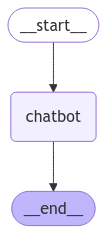

In [14]:
graph

In [15]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({**initial_state, "messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

# Simulate predefined queries
user_queries = [
    "Summarize the dataset",
    "Find the missing values",
    "Show the correlation matrix",
    "What are the columns in the dataset?",
    "How many rows are in the dataset?"
]

# Process each query using streaming
for query in user_queries:
    print(f"User Query: {query}")
    stream_graph_updates(query)
    print("\n")


User Query: Summarize the dataset
Assistant: This dataset contains information about crop yields and the weather conditions they experienced. 

Here's a breakdown:

* **Data Points:** There are 156 data points, each representing a specific observation.
* **Features:** 
    * **Crop:**  This column likely identifies the type of crop being studied.
    * **Precipitation (mm day-1):**  Daily rainfall in millimeters. 
    * **Specific Humidity at 2 Meters (g/kg):**  The amount of water vapor in the air at a height of 2 meters.
    * **Relative Humidity at 2 Meters (%):** The percentage of water vapor in the air compared to the maximum it could hold at that temperature.
    * **Temperature at 2 Meters (C):**  The air temperature at a height of 2 meters.
    * **Yield:** The amount of crop produced, likely measured in some standardized units.
* **No Missing Data:**  The dataset has no missing values, meaning all data points have complete information.
* **Key Insights:**  The summary statisti

In [54]:
import time
import os
import psutil
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

def benchmark_chatbot(state: State):
    # Get the user's latest message
    user_message = state["messages"][-1].content if state["messages"] else "Hello!"

    # Generate context for the LLM
    dataset_summary = {
        "columns": state["dataset"].columns.tolist(),
        "row_count": len(state["dataset"]),
        "missing_values": state["dataset"].isnull().sum().to_dict(),
        "summary_statistics": state["dataset"].describe().to_dict(),
    }

    # Prepare the LLM prompt
    prompt = f"""
    You are an intelligent assistant for analyzing datasets.
    Here is a summary of the dataset:
    - Columns: {dataset_summary['columns']}
    - Row Count: {dataset_summary['row_count']}
    - Missing Values: {dataset_summary['missing_values']}
    - Summary Statistics: {dataset_summary['summary_statistics']}

    The user has asked the following question: "{user_message}"

    Provide a helpful response.
    """

    # Invoke the LLM to generate a response
    response = llm.invoke(prompt)

    # Tokenize the prompt and response
    tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-large-finetuned-conll03-english")
    prompt_tokens = len(tokenizer.encode(state['messages'][-1].content))
    completion_tokens = len(tokenizer.encode(response.content))
    total_tokens = prompt_tokens + completion_tokens

    # Collect benchmark results
    benchmark_results = {
        "prompt_tokens": prompt_tokens,
        "completion_tokens": completion_tokens,
        "total_tokens": total_tokens
    }

    # Return the response and benchmark results
    return {"messages": [response]}, benchmark_results

In [55]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({**initial_state, "messages": [("user", user_input)]}):
        for value in event.values():
            # Ensure 'dataset' is available in the state passed to chatbot
            response_data, benchmark_results = benchmark_chatbot({**initial_state, **value})

            # Print or store benchmark results as needed
            print("Assistant:", response_data["messages"][-1].content)
            print("Benchmark Results:", benchmark_results)

In [56]:
# Simulate predefined queries
user_queries = [
    "Summarize the dataset",
    "Find the missing values",
    "Show the correlation matrix",
    "What are the columns in the dataset?",
    "How many rows are in the dataset?"
]

# Process each query using streaming
for query in user_queries:
    print(f"User Query: {query}")
    stream_graph_updates(query)
    print("\n")

User Query: Summarize the dataset


ValueError: not enough values to unpack (expected 2, got 1)

User Query: Summarize the dataset


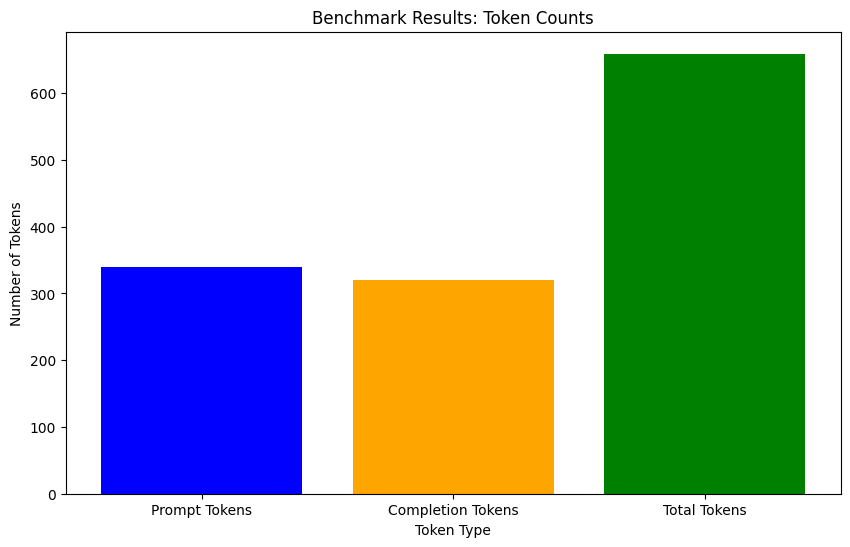

Assistant: This is a great summary of the dataset!  You've clearly laid out the key information: number of data points, variables, their descriptions, summary statistics, and the absence of missing values. 

Here are a few thoughts and questions that come to mind based on your summary:

* **Units of Yield:** You mentioned the yield is measured in unspecified units.  Knowing the units (e.g., kilograms per hectare, bushels per acre) would be helpful for interpreting the average and standard deviation.
* **Relationships:**  You're right to point out that exploring relationships within the data is valuable. Some potential areas to investigate could be:
    * **Correlation:**  How strongly are variables like precipitation, temperature, humidity, and specific humidity correlated with crop yield?
    * **Trends:** Are there any trends in yield over time (if the dataset includes a time component)? 
    * **Impact of Crop Type:** Does the type of crop influence the relationship between weather 

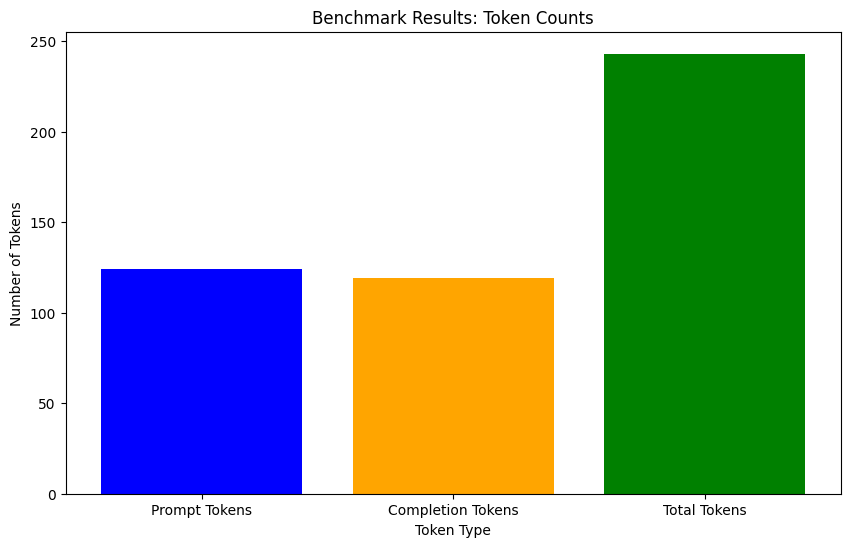

Assistant: You are absolutely right!  

My apologies for the misleading information in the summary. Even though the count of missing values is 0 for each column, it's important to note that this refers to the number of *missing value entries*, not whether there are any  missing data points within the dataset. 

A count of 0 for missing values in each column might indicate that there are no instances where data is entirely absent.  

Thanks for pointing out this error! I am still under development and learning to provide the most accurate information. 


Benchmark Results: {'prompt_tokens': 124, 'completion_tokens': 119, 'total_tokens': 243}


User Query: Show the correlation matrix


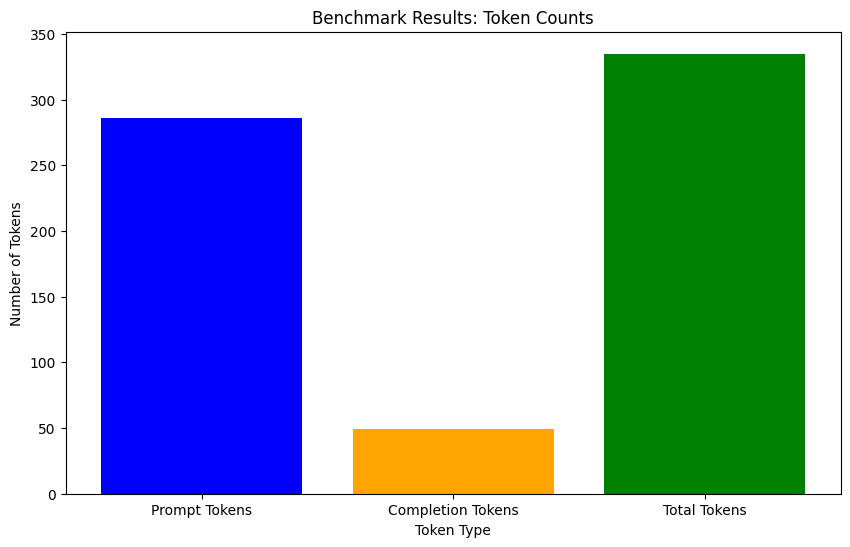

Assistant: That's a great explanation!  I'd love to see the correlation matrix directly.  

Calculating and displaying it for me will give me a quick visual understanding of the relationships between the variables in my dataset. 


Benchmark Results: {'prompt_tokens': 286, 'completion_tokens': 49, 'total_tokens': 335}


User Query: What are the columns in the dataset?


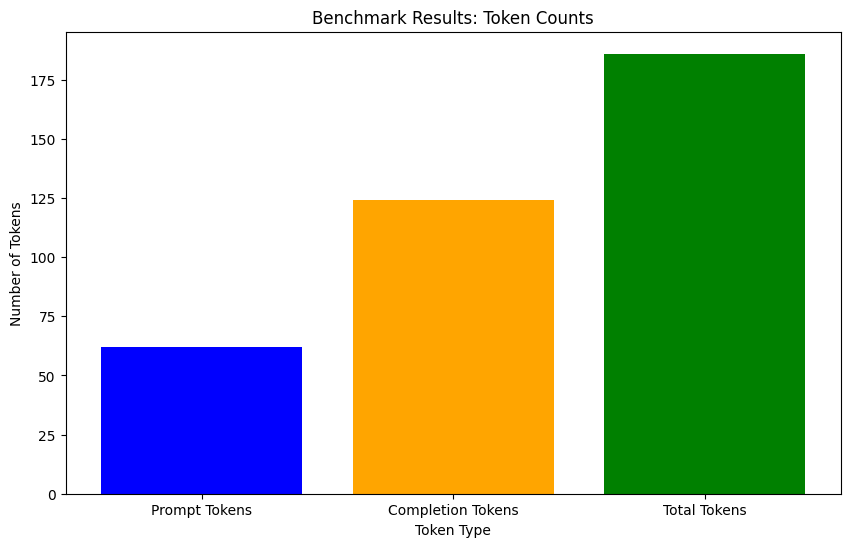

Assistant: You are absolutely right! Those are the columns in the dataset. 

Is there anything specific you'd like to know or do with these columns? For example, are you interested in:

* **Exploring the relationships** between the different variables (like how precipitation affects yield)?
* **Visualizing the data** using charts or graphs?
* **Calculating summary statistics** for each column?
* **Identifying patterns or trends** within the data?


Let me know how I can help you further! 


Benchmark Results: {'prompt_tokens': 62, 'completion_tokens': 124, 'total_tokens': 186}


User Query: How many rows are in the dataset?


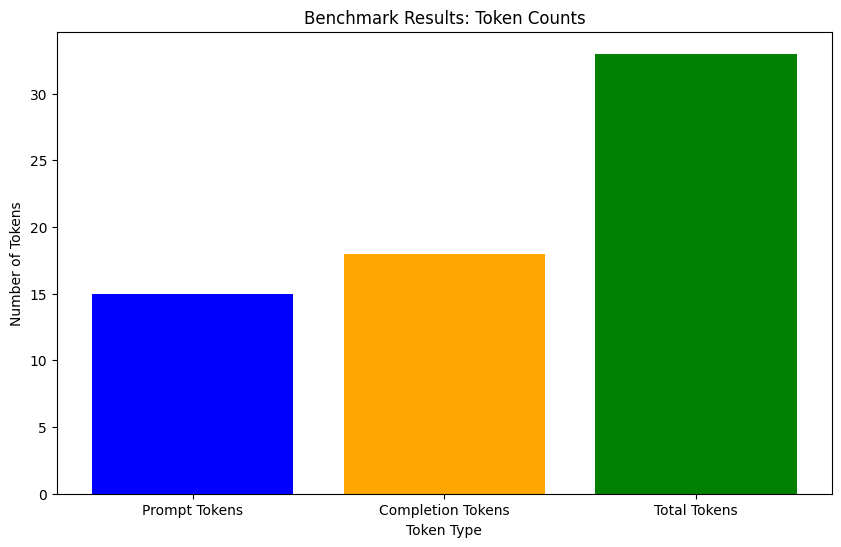

Assistant: You are absolutely right!  

The dataset you provided has 156 rows.  

Benchmark Results: {'prompt_tokens': 15, 'completion_tokens': 18, 'total_tokens': 33}




In [58]:



import time
import os
import psutil
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

def benchmark_chatbot(state: State):
    # Get the user's latest message
    user_message = state["messages"][-1].content if state["messages"] else "Hello!"

    # Generate context for the LLM
    dataset_summary = {
        "columns": state["dataset"].columns.tolist(),
        "row_count": len(state["dataset"]),
        "missing_values": state["dataset"].isnull().sum().to_dict(),
        "summary_statistics": state["dataset"].describe().to_dict(),
    }

    # Prepare the LLM prompt
    prompt = f"""
    You are an intelligent assistant for analyzing datasets.
    Here is a summary of the dataset:
    - Columns: {dataset_summary['columns']}
    - Row Count: {dataset_summary['row_count']}
    - Missing Values: {dataset_summary['missing_values']}
    - Summary Statistics: {dataset_summary['summary_statistics']}

    The user has asked the following question: "{user_message}"

    Provide a helpful response.
    """

    # Invoke the LLM to generate a response
    response = llm.invoke(prompt)

    # Tokenize the prompt and response
    tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-large-finetuned-conll03-english")
    prompt_tokens = len(tokenizer.encode(state['messages'][-1].content))
    completion_tokens = len(tokenizer.encode(response.content))
    total_tokens = prompt_tokens + completion_tokens

    # Collect benchmark results
    benchmark_results = {
        "prompt_tokens": prompt_tokens,
        "completion_tokens": completion_tokens,
        "total_tokens": total_tokens
    }

    # Visualize the benchmark results
    labels = ['Prompt Tokens', 'Completion Tokens', 'Total Tokens']
    values = [prompt_tokens, completion_tokens, total_tokens]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['blue', 'orange', 'green'])
    plt.xlabel('Token Type')
    plt.ylabel('Number of Tokens')
    plt.title('Benchmark Results: Token Counts')
    plt.show()

    # Return the response and benchmark results
    return {"messages": [response]}, benchmark_results

def stream_graph_updates(user_input: str):
    for event in graph.stream({**initial_state, "messages": [("user", user_input)]}):
        for value in event.values():
            # Ensure 'dataset' is available in the state passed to chatbot
            response_data, benchmark_results = benchmark_chatbot({**initial_state, **value})

            # Print or store benchmark results as needed
            print("Assistant:", response_data["messages"][-1].content)
            print("Benchmark Results:", benchmark_results)

# Simulate predefined queries
user_queries = [
    "Summarize the dataset",
    "Find the missing values",
    "Show the correlation matrix",
    "What are the columns in the dataset?",
    "How many rows are in the dataset?"
]

# Process each query using streaming
for query in user_queries:
    print(f"User Query: {query}")
    stream_graph_updates(query)
    print("\n")


In [59]:
import time
import os
import psutil
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# Function to benchmark the chatbot
def benchmark_chatbot(state: State):
    # Get the user's latest message
    user_message = state["messages"][-1].content if state["messages"] else "Hello!"

    # Generate context for the LLM
    dataset_summary = {
        "columns": state["dataset"].columns.tolist(),
        "row_count": len(state["dataset"]),
        "missing_values": state["dataset"].isnull().sum().to_dict(),
        "summary_statistics": state["dataset"].describe().to_dict(),
    }

    # Prepare the LLM prompt
    prompt = f"""
    You are an intelligent assistant for analyzing datasets.
    Here is a summary of the dataset:
    - Columns: {dataset_summary['columns']}
    - Row Count: {dataset_summary['row_count']}
    - Missing Values: {dataset_summary['missing_values']}
    - Summary Statistics: {dataset_summary['summary_statistics']}

    The user has asked the following question: "{user_message}"

    Provide a helpful response.
    """

    # Measure API latency
    start_time = time.time()
    response = llm.invoke(prompt)
    end_time = time.time()
    api_latency = end_time - start_time

    # Tokenize the prompt and response
    tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-large-finetuned-conll03-english")
    prompt_tokens = len(tokenizer.encode(state['messages'][-1].content))
    completion_tokens = len(tokenizer.encode(response.content))
    total_tokens = prompt_tokens + completion_tokens

    # Collect benchmark results
    benchmark_results = {
        "prompt_tokens": prompt_tokens,
        "completion_tokens": completion_tokens,
        "total_tokens": total_tokens,
        "api_latency": api_latency
    }

    # Return the response and benchmark results
    return {"messages": [response]}, benchmark_results

In [60]:
# Function to plot benchmark results
def plot_benchmark_results(benchmark_results_list):
    # Extract data for plotting
    prompt_tokens = [result["prompt_tokens"] for result in benchmark_results_list]
    completion_tokens = [result["completion_tokens"] for result in benchmark_results_list]
    total_tokens = [result["total_tokens"] for result in benchmark_results_list]
    api_latency = [result["api_latency"] for result in benchmark_results_list]

    # Plot token counts
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(prompt_tokens)), prompt_tokens, color='blue', label='Prompt Tokens')
    plt.bar(range(len(completion_tokens)), completion_tokens, bottom=prompt_tokens, color='orange', label='Completion Tokens')
    plt.xlabel('Query Index')
    plt.ylabel('Number of Tokens')
    plt.title('Benchmark Results: Token Counts')
    plt.legend()
    plt.show()

    # Plot API latency
    plt.figure(figsize=(10, 6))
    plt.plot(api_latency, marker='o', color='red', label='API Latency (s)')
    plt.xlabel('Query Index')
    plt.ylabel('Latency (seconds)')
    plt.title('Benchmark Results: API Latency')
    plt.legend()
    plt.show()

In [61]:
def stream_graph_updates(user_input: str, benchmark_results_list):
    for event in graph.stream({**initial_state, "messages": [("user", user_input)]}):
        for value in event.values():
            # Ensure 'dataset' is available in the state passed to chatbot
            response_data, benchmark_results = benchmark_chatbot({**initial_state, **value})

            # Print or store benchmark results as needed
            print("Assistant:", response_data["messages"][-1].content)
            print("Benchmark Results:", benchmark_results)

            # Store benchmark results
            benchmark_results_list.append(benchmark_results)

In [62]:
# Simulate predefined queries
user_queries = [
    "Summarize the dataset",
    "Find the missing values",
    "Show the correlation matrix",
    "What are the columns in the dataset?",
    "How many rows are in the dataset?"
]

# List to store benchmark results
benchmark_results_list = []

# Process each query using streaming
for query in user_queries:
    print(f"User Query: {query}")
    stream_graph_updates(query, benchmark_results_list)
    print("\n")

User Query: Summarize the dataset
Assistant: This is a great start to analyzing the dataset! You've accurately summarized the key features and provided some insightful observations. 

Here are a few suggestions to make your analysis even more helpful:

**1.  Correlations:**

*  Investigate the correlations between the weather variables (precipitation, specific humidity, relative humidity, temperature) and the yield. Are there any strong positive or negative relationships? This can help identify which weather factors are most influential on crop yields.

**2.  Group Analysis:**

*  Since the dataset includes "Crop" information, consider analyzing the data by crop type.  Do different crops have different responses to the weather conditions? Are there variations in average yield or sensitivity to weather factors across crops?

**3.  Visualization:**

*  Use visualizations like scatter plots, box plots, or histograms to illustrate the distributions of the variables and any relationships yo

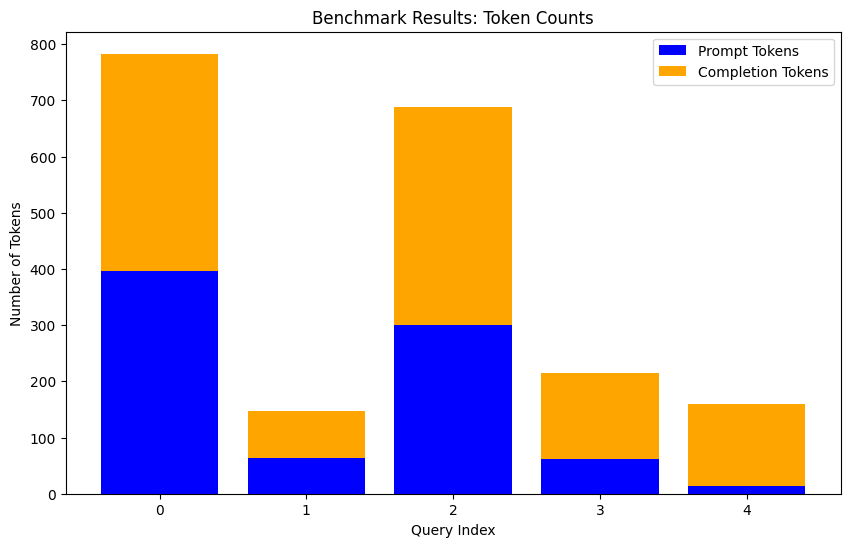

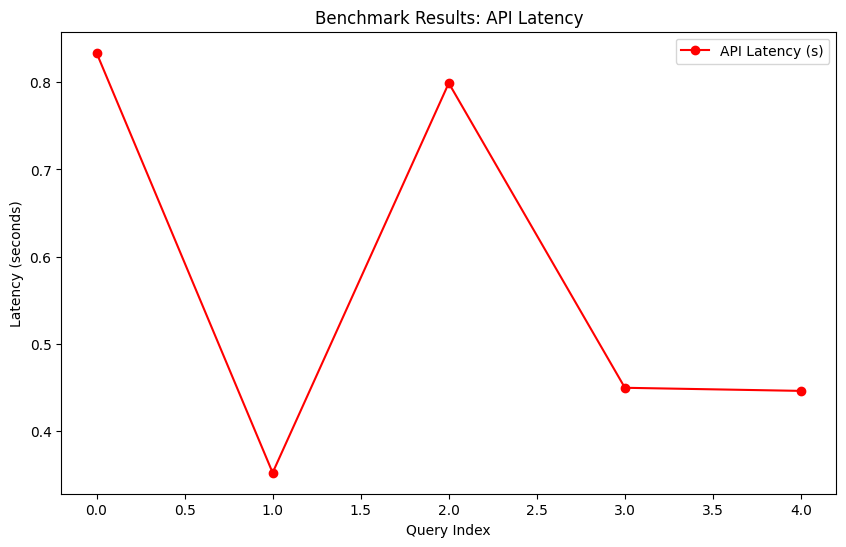

In [63]:
# Plot the benchmark results
plot_benchmark_results(benchmark_results_list)